<a href="https://colab.research.google.com/github/MinsooKwak/Study/blob/main/DataManipulate/GAN/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dataset : [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview)

- 필사 참고 : https://www.kaggle.com/code/ohseokkim/transfering-style

In [ ]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Sep 11 14:31 .
drwx------ 1 root root 4096 Sep 11 14:27 ..
-rw------- 1 root root   72 Sep 11 14:31 kaggle.json


In [5]:
#!kaggle competitions list

In [6]:
!kaggle competitions download -c gan-getting-started

 98% 361M/367M [00:08<00:00, 30.6MB/s]
100% 367M/367M [00:08<00:00, 47.5MB/s]


In [ ]:
!unzip /content/gan-getting-started.zip

In [8]:
ls

 drive/                    kaggle.json    photo_jpg/
 gan-getting-started.zip   monet_jpg/     photo_tfrec/
'kaggle (1).json'          monet_tfrec/   sample_data/


## Neutral Style Transfer

In [9]:
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

### Load Model

VGG19
- vgg19.features : all conv layers + pool layers
- vgg19.classifier : last 3 linear layer + classifier layer

In [10]:
vgg = models.vgg19(pretrained=True).features

# freeze to use weight (not update)
for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# 사용 가능시 GPU 활용

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load Content and Style Images

In [12]:
def load_image(img_path, max_size=128, shape=None):
  if "http" in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image = Image.open(img_path).convert('RGB')

  # image size
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),
                           (0.229, 0.224, 0.225))
  ])

  image = in_transform(image)[:3,:,:].unsqueeze(0)

  return image

In [13]:
# load content
content = load_image('/content/photo_jpg/00068bc07f.jpg').to(device)

# match content
style = load_image('/content/monet_jpg/058f878b7c.jpg').to(device)

In [14]:
# normalize image function
def im_convert(tensor):
  '''
  '''
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)

  return image

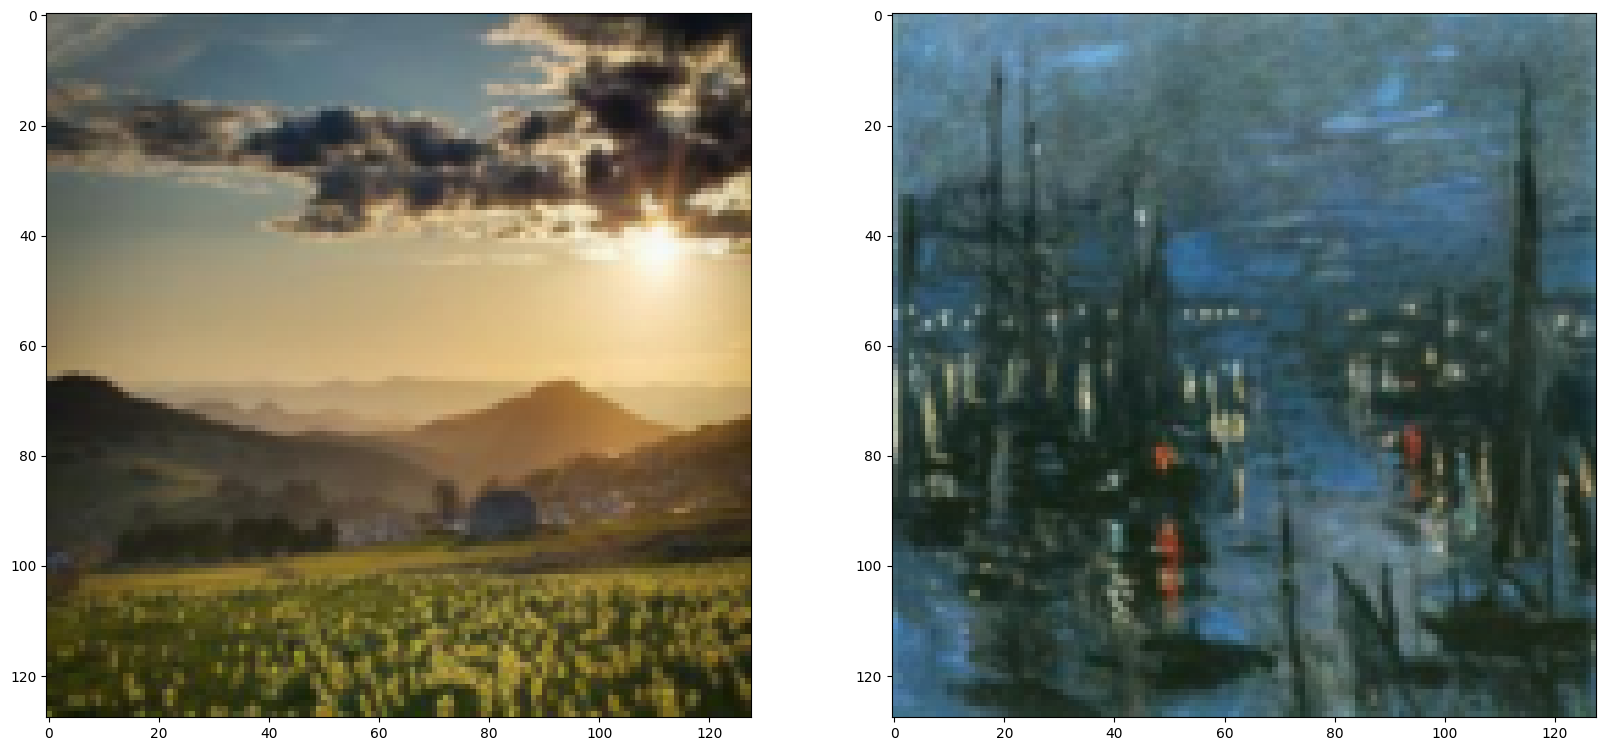

In [15]:
# display image
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [19]:
def get_features(image, model, layers=None):
  '''
  get the features for a set of layers
  VGGNet matching Gatys et al (2016)
  '''
  if layers is None:
    layers = {'0': 'conv1_1',
             '5': 'conv2_1',
             '10':'conv3_1',
             '19':'conv4_1',
             '21':'conv4_2',  # content representation
             '28':'conv5_1'}

  features = {}
  x = image

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

Gram Matrix

In [17]:
def gram_matrix(tensor):
  # get batch_size, depth, height, width of Tensor
  _, d, h, w = tensor.size()

  # reshape : multiplying features for each channel
  tensor = tensor.view(d, h*w)

  # gram matrix calculate
  gram = torch.mm(tensor, tensor.t())

  return gram

In [20]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

Define Losses and Weights

In [21]:
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e3  # beta

Total loss:  173.4122314453125


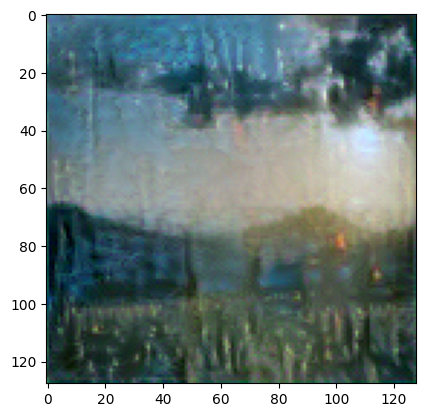

Total loss:  132.66473388671875


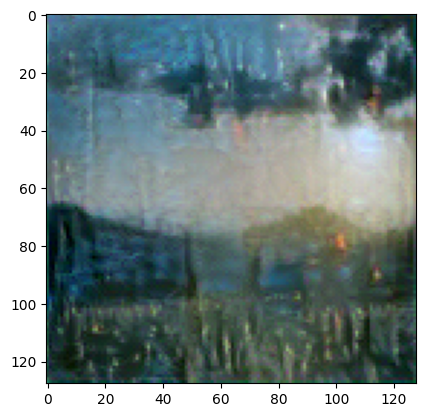

Total loss:  109.97251892089844


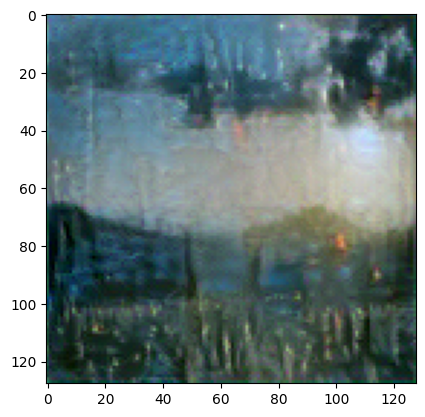

Total loss:  95.28077697753906


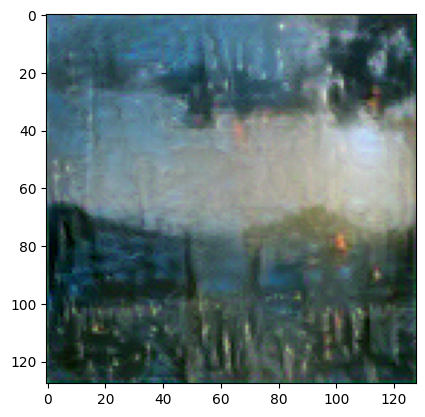

In [26]:
# display image 간격
show_every = 50

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 201  # iterations to update your image (200)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    style_loss = 0  # 0으로 초기화
    # 그리고 각 layer의 gram matrix loss에 더해줌
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # total loss 계산
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()